In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)

from time import time_ns
from amftrack.util.dbx import (
    upload_folders,
    load_dbx,
    download,
    get_dropbox_folders_prince,
)
from datetime import datetime
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.dbx import read_saved_dropbox_state, get_dropbox_folders_prince
import sys
import os

from amftrack.util.sys import get_dirname, temp_path
import pandas as pd
import ast
from scipy import sparse
import scipy.io as sio
import cv2
import imageio.v2 as imageio
import numpy as np
import scipy.sparse
import os
from time import time
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

from amftrack.util.sys import get_dates_datetime, get_dirname
import shutil
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from matplotlib import cm
from matplotlib.patches import Rectangle
from amftrack.transport.align_video_network import identify_nodes, selected_rectangle
from IPython.display import clear_output
import re
from amftrack.pipeline.development.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.development.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox,
    analysis_run,
)
from amftrack.pipeline.development.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis,
)
import sys
import os
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from tifffile import imwrite
from tqdm import tqdm
import scipy
import matplotlib as mpl
from pathlib import Path
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
import dropbox
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from subprocess import call
import logging
import datetime
import glob
import json
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.util.dbx import upload
from amftrack.pipeline.functions.image_processing.experiment_util import (
    make_full_image,
    plot_full_video,
)

mpl.rcParams["figure.dpi"] = 60

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-09-05 14:49:42.836468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 14:49:43.067490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home2/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/cv2/../../lib64:
2023-09-05 14:49:43.067543: I tensorflow/stream_executor/cuda/cudart_stub.cc:29

In [2]:
plate_id = "449_20230807"
plate_id_video = "20230813_Plate449"

In [6]:
analysis_folder = "/projects/0/einf914/analysis_videos/"
analysis_folder = f"{analysis_folder}{plate_id_video}/"

img_infos = glob.glob(f"{analysis_folder}/**/video_data.json", recursive=True)
vid_anls_frame = pd.DataFrame()
add_infos = []
for address in img_infos:
    add_infos.append(pd.read_json(address, orient="index").T)
vid_anls_frame = pd.concat([vid_anls_frame] + add_infos, ignore_index=True)

vid_anls_frame = vid_anls_frame.sort_values("unique_id").reset_index(drop=True)
vid_anls_frame_select = vid_anls_frame.loc[vid_anls_frame["plate_id"] == plate_id_video]

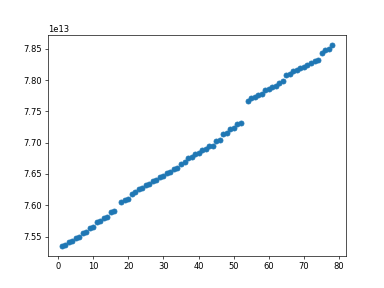

In [7]:
fig, ax = plt.subplots()
vid_anls_frame_select["timedelta"] = pd.to_timedelta(
    vid_anls_frame_select["record_time"]
)

ax.scatter(vid_anls_frame_select["video_int"], vid_anls_frame_select["timedelta"])

In [11]:
vid_anls_frame_select["record_time"][0]

' 20:55:45'

In [8]:
plates = [plate_id]

In [9]:
# directory_targ = os.path.join(directory_scratch, "stitch_temp2") + "/"
directory_targ = directory_project

update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/1228 [00:00<?, ?it/s]

In [9]:
all_folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,Temp,unique_id,datetime
0,/projects/0/einf914/data/20230813_2230_Plate14,441,14,'Carrot','C2','001P100N100C','Y','-',20230807,25,...,False,True,True,True,True,"13.08.2023, 22:30:",20230813_2230_Plate14,NaN,441_20230807,2023-08-13 22:30:00
1,/projects/0/einf914/data/20230520_0953_Plate05,910,5,'Nicotiana','C2','001P100N100C','Y','-',202305016,25,...,False,True,True,True,True,"20.05.2023, 09:53:",20230520_0953_Plate05,NaN,910_202305016,2023-05-20 09:53:00
2,/projects/0/einf914/data/20220607_2252_Plate34,13,34,'Carrot','A5','001P100N200C','Y','-',20220422,25,...,False,True,True,True,True,"07.06.2022, 22:52:",20220607_2252_Plate34,NaN,13_20220422,2022-06-07 22:52:00
3,/projects/0/einf914/data/20220428_1255_Plate16,3,16,'Carrot','Agg','001P100N100C','Y','-',20220426,25,...,False,True,True,True,True,"28.04.2022, 12:55:",20220428_1255_Plate16,NaN,3_20220426,2022-04-28 12:55:00
4,/projects/0/einf914/data/20220505_0143_Plate18,13,18,'Carrot','Agg','001P100N100C','Y','-',20220422,25,...,False,False,False,False,False,"05.05.2022, 01:43:",20220505_0143_Plate18,NaN,13_20220422,2022-05-05 01:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,/projects/0/einf914/data/20220430_1707_Plate10,16,10,'Carrot','Agg','001P100N100C','Y','-',20220419,25,...,False,False,False,False,False,"30.04.2022, 17:07:",20220430_1707_Plate10,NaN,16_20220419,2022-04-30 17:07:00
1786,/projects/0/einf914/data/20230525_0755_Plate05,910,5,'Nicotiana','C2','001P100N100C','Y','-',202305016,25,...,False,True,True,True,True,"25.05.2023, 07:55:",20230525_0755_Plate05,NaN,910_202305016,2023-05-25 07:55:00
1787,/projects/0/einf914/data/20220516_1025_Plate13,12,13,'Carrot','Agg','001P100N100C','Y','-',20220502,25,...,False,True,True,False,False,"16.05.2022, 10:25:",20220516_1025_Plate13,NaN,12_20220502,2022-05-16 10:25:00
1788,/projects/0/einf914/data/20201124_1902_Plate39,94,39,'Carrot','A5','001P100N','Y',NaN,'20201123',NaN,...,False,True,True,True,True,"24.11.2020, 19:02:",20201124_1902_Plate39,'25',94_20201123,2020-11-24 19:02:00


In [12]:
folders = all_folders.loc[all_folders["unique_id"] == plates[0]]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_labeled.p"] == True]

In [16]:
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
i = 64
exp.load(folders.iloc[i : i + 2], suffix="_width")
for t in range(exp.ts):
    exp.load_tile_information(t)

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-08-13 20:09:00
2023-08-13 22:19:00


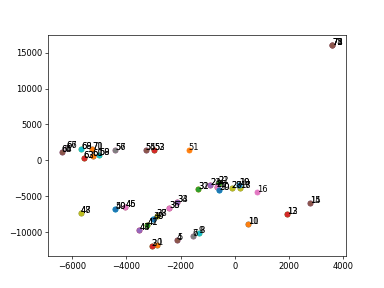

In [17]:
positions = np.array(vid_anls_frame_select[["ypos", "xpos"]]) * 1000 / 1.725
fig, ax = plt.subplots()
for i, pos in enumerate(positions):
    ax.text(int(pos[0]), int(pos[1]), str(i))
    ax.scatter(int(pos[0]), int(pos[1]))

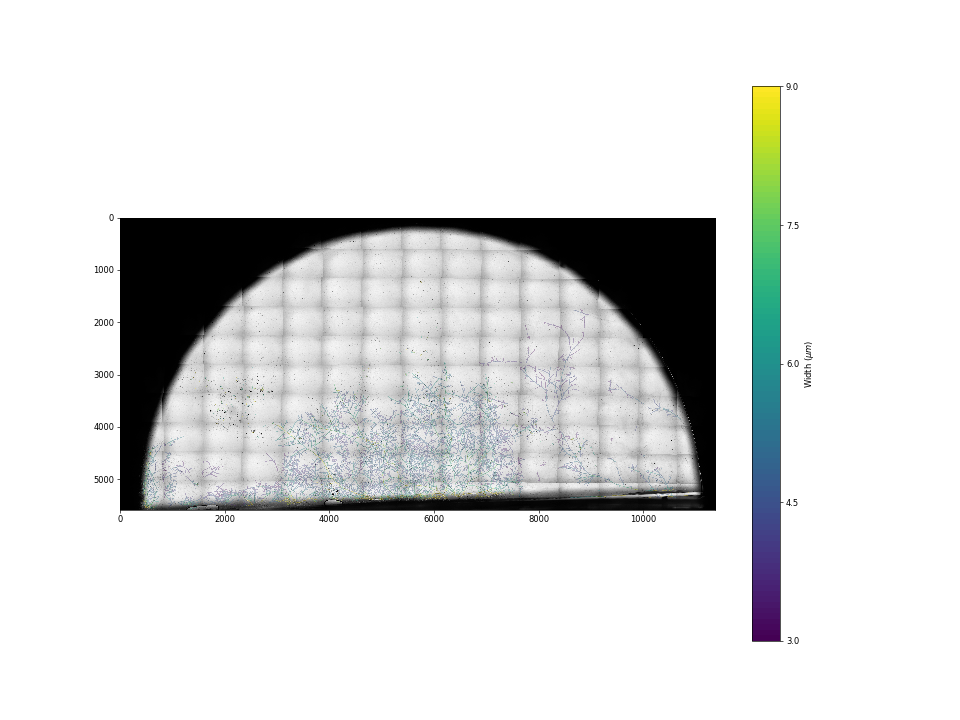

Text(value='', description='Point name:', placeholder='Type point name here')

In [19]:
cid, dicopoint = identify_nodes(exp, 0)

In [28]:
del dicopoint["53"]

In [31]:
keys = list(dicopoint.keys())
posnodes = [dicopoint[key].pos(0).tolist() for key in keys]
posvideoslines = [
    vid_anls_frame_select.loc[vid_anls_frame_select["video_int"] == int(key)]
    for key in keys
]
posvideos = [
    [
        posvideosline["ypos"].astype(float).iloc[0] * 1000 / 1.725,
        posvideosline["xpos"].astype(float).iloc[0] * 1000 / 1.725,
    ]
    for posvideosline in posvideoslines
]

In [32]:
from amftrack.util.image_analysis import find_transformation, find_similarity

transform = find_similarity(posvideos, posnodes)

[1.1211046508653648, 1.155638274133946, 1.1251769163859509, 1.1284398762456214, 1.1227568941236472, 1.1830317625854636, 1.102864701016625, 1.1156054844360457, 1.12260615358276, 1.133157935646741, 1.1391302688616016, 1.1274385428998992, 1.1041727110358877, 1.1201260571175036, 1.1216774571449764]
Similarity ratio: 1.1227568941236472
Similarity is a positive similarity
Rotation: [[ 0.99521013 -0.09775888]
 [ 0.09775888  0.99521013]]
Translation: [22785.18017272 29932.04515583]


similarity_ratio should be 1.128

In [33]:
posvideos_new = [transform(pos) for pos in posvideos]
posvideos_new, posnodes

([array([21628.58598171, 17245.1650572 ]),
  array([22205.03823645, 17974.7619551 ]),
  array([22415.59713141, 18534.34610802]),
  array([20164.1582002, 19549.9143016]),
  array([20326.89974634, 20429.84245058]),
  array([15670.72070389, 31138.9701275 ])],
 [[21565, 17221],
  [22140, 17950],
  [22456, 18495],
  [20225, 19607],
  [20387, 20472],
  [15638, 31128]])

In [34]:
positions = np.array(vid_anls_frame_select[["ypos", "xpos"]]) * 1000 / 1.725
positions_list = positions.tolist()
posvideos_new_list = [transform(pos) for pos in positions_list]

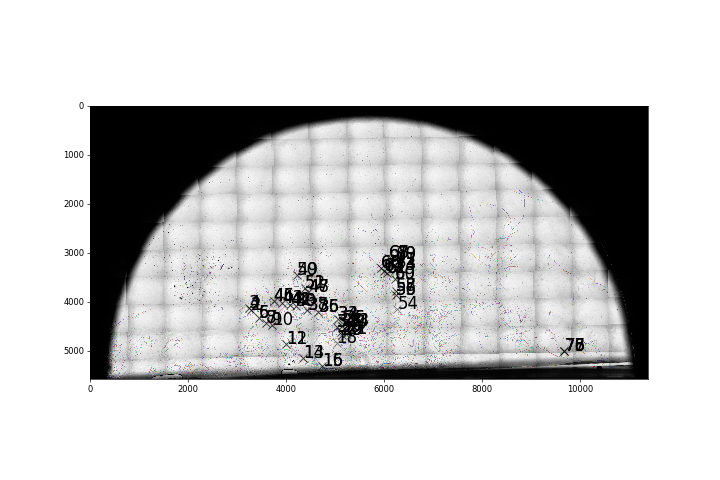

<AxesSubplot:>

In [37]:
vmax = 9
vmin = 3
region = None
nodes = get_all_nodes(exp, t)
edges = get_all_edges(exp, t)

downsizing = 5

plot_full_video(
    exp,
    t,
    downsizing=downsizing,
    points=posvideos_new_list,
    video_num=vid_anls_frame_select["video_int"],
    edges=edges,
    dilation=5,
)

In [38]:
img_infos = glob.glob(f"{analysis_folder}/**/video_data.json", recursive=True)
for address in img_infos:
    add_info = pd.read_json(address, orient="index").T
    if add_info["plate_id"].iloc[0] == plate_id_video:
        positions = np.array(add_info[["ypos", "xpos"]]) * 1000 / 1.725
        positions_list = positions.tolist()
        posvideos_new_list = [transform(pos) for pos in positions_list]
        add_info["xpos_network"] = posvideos_new_list[0][0]
        add_info["ypos_network"] = posvideos_new_list[0][1]
        add_info.to_json(address)
        # break

In [39]:
img_infos = glob.glob(f"{analysis_folder}/**/video_data.json", recursive=True)
vid_anls_frame = pd.DataFrame()
for address in img_infos:
    add_info = pd.read_json(address, orient="index").T
    if add_info["plate_id"].iloc[0] == plate_id_video:
        original_path = add_info["tot_path_drop"].iloc[0]

        # Replace the specific substring in the target path
        target_path = original_path.replace(
            f"/{plate_id_video}", f"/Analysis/{plate_id_video}"
        )
        target = "/" + target_path + "/video_data_network.json"
        source = address
        upload(
            source,
            target,
            chunk_size=256 * 1024 * 1024,
        )
        print(target)
    # break

2023-09-05 15:18:42,432-[INFO]- dropbox:390 -> Refreshing access token.
2023-09-05 15:18:42,764-[INFO]- dropbox:474 -> Request to files/upload
/DATA/CocoTransport/Analysis/20230813_Plate449/068/Img/video_data_network.json
2023-09-05 15:18:43,722-[INFO]- dropbox:390 -> Refreshing access token.
2023-09-05 15:18:43,874-[INFO]- dropbox:474 -> Request to files/upload
/DATA/CocoTransport/Analysis/20230813_Plate449/018/Img/video_data_network.json
2023-09-05 15:18:44,598-[INFO]- dropbox:390 -> Refreshing access token.
2023-09-05 15:18:44,822-[INFO]- dropbox:474 -> Request to files/upload
/DATA/CocoTransport/Analysis/20230813_Plate449/014/Img/video_data_network.json
2023-09-05 15:18:45,816-[INFO]- dropbox:390 -> Refreshing access token.
2023-09-05 15:18:45,967-[INFO]- dropbox:474 -> Request to files/upload
/DATA/CocoTransport/Analysis/20230813_Plate449/056/Img/video_data_network.json
2023-09-05 15:18:46,792-[INFO]- dropbox:390 -> Refreshing access token.
2023-09-05 15:18:46,941-[INFO]- dropbox:

In [41]:
t = 0
im, skel_im = make_full_image(
    exp, t, downsizing=5, dilation=5, edges=get_all_edges(exp, t)
)

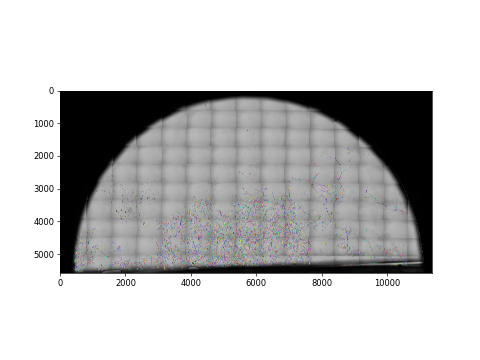

In [42]:
im_rgba = np.stack([im, im, im, np.ones(im.shape, dtype=im.dtype) * 255], axis=-1)
white_mask = np.all(skel_im[:, :, :3] == 255, axis=-1)
skel_im[white_mask, 3] = 0  # setting alpha to 0 where it's white
# Convert numpy arrays to PIL images
im_pil = Image.fromarray(im_rgba.astype(np.uint8))
skel_im_pil = Image.fromarray(skel_im.astype(np.uint8))


# Overlay the images
combined = Image.alpha_composite(im_pil, skel_im_pil)
combined.save(os.path.join(analysis_folder, "network_overlay.png"))
im_pil.save(os.path.join(analysis_folder, "stitched.png"))

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(combined)

In [43]:
source = os.path.join(analysis_folder, "network_overlay.png")
original_path = vid_anls_frame_select["tot_path_drop"].iloc[0]
new_path = os.path.dirname(os.path.dirname(original_path))
new_path = "/" + new_path
target = new_path + "/network_overlay.png"
target = target.replace(f"/{plate_id_video}", f"/Analysis/{plate_id_video}")

upload(
    source,
    target,
    chunk_size=256 * 1024 * 1024,
)
source = os.path.join(analysis_folder, "stitched.png")

target = new_path + "/stitched.png"
target = target.replace(f"/{plate_id_video}", f"/Analysis/{plate_id_video}")

upload(
    source,
    target,
    chunk_size=256 * 1024 * 1024,
)

2023-09-05 15:21:44,613-[INFO]- dropbox:390 -> Refreshing access token.
2023-09-05 15:21:44,781-[INFO]- dropbox:474 -> Request to files/upload
2023-09-05 15:21:47,471-[INFO]- dropbox:390 -> Refreshing access token.
2023-09-05 15:21:47,630-[INFO]- dropbox:474 -> Request to files/upload


In [36]:
def plot_full_video(
    exp: Experiment,
    t: int,
    region=None,
    edges: List[Edge] = [],
    points: List[coord_int] = [],
    video_num: List[int] = [],
    segments: List[List[coord_int]] = [],
    nodes: List[Node] = [],
    downsizing=5,
    dilation=1,
    save_path="",
    prettify=False,
    with_point_label=False,
    figsize=(12, 8),
    dpi=None,
    node_size=5,
) -> None:
    """
    This is the general purpose function to plot the full image or a region `region` of the image at
    any given timestep t. The region being specified in the GENERAL coordinates.
    The image can be downsized by a chosen factor `downsized` with additionnal features such as: edges, nodes, points, segments.
    The coordinates for all the objects are provided in the GENERAL referential.

    :param region: choosen region in the full image, such as [[100, 100], [2000,2000]], if None the full image is shown
    :param edges: list of edges to plot, it is the pixel list that is plotted, not a straight line
    :param nodes: list of nodes to plot (only nodes in the `region` will be shown)
    :param points: points such as [123, 234] to plot with a red cross on the image
    :param segments: plot lines between two points that are provided
    :param downsizing: factor by which we reduce the image resolution (5 -> image 25 times lighter)
    :param dilation: only for edges: thickness of the edges (dilation applied to the pixel list)
    :param save_path: full path to the location where the plot will be saved
    :param prettify: if True, the image will be enhanced by smoothing the intersections between images
    :param with_point_label: if True, the index of the point is ploted on top of it

    NB: the full region of a full image is typically [[0, 0], [26000, 52000]]
    NB: the interesting region of a full image is typically [[12000, 15000], [26000, 35000]]
    NB: the colors are chosen randomly for edges
    NB: giving a smaller region greatly increase computation time
    """

    # TODO(FK): fetch image size from experiment object here, and use it in reconstruct image
    # TODO(FK): colors for edges are not consistent
    # NB: possible other parameters that could be added: alpha between layers, colors for object, figure_size
    DIM_X, DIM_Y = get_dimX_dimY(exp)

    if region == None:
        # Full image
        image_coodinates = exp.image_coordinates[t]
        region = get_bounding_box(image_coodinates)
        region[1][0] += DIM_X  # TODO(FK): Shouldn't be hardcoded
        region[1][1] += DIM_Y

    # 1/ Image layer
    im, f = reconstruct_image_from_general(
        exp,
        t,
        downsizing=downsizing,
        region=region,
        prettify=prettify,
        white_background=False,  # TODO(FK): add image dimention here dimx = ..
    )
    f_int = lambda c: f(c).astype(int)
    new_region = [
        f_int(region[0]),
        f_int(region[1]),
    ]  # should be [[0, 0], [d_x/downsized, d_y/downsized]]

    # 2/ Edges layer
    skel_im, _ = reconstruct_skeletton(
        [edge.pixel_list(t) for edge in edges],
        region=region,
        color_seeds=[(edge.begin.label + edge.end.label) % 255 for edge in edges],
        downsizing=downsizing,
        dilation=dilation,
    )

    # 3/ Fusing layers
    fig = plt.figure(
        figsize=figsize
    )  # width: 30 cm height: 20 cm # TODO(FK): change dpi
    ax = fig.add_subplot(111)
    ax.imshow(im, cmap="gray", interpolation="none")
    ax.imshow(skel_im, alpha=0.5, interpolation="none")

    # 3/ Plotting the Nodes
    size = node_size
    for node in nodes:
        c = f(list(node.pos(t)))
        color = make_random_color(node.label)[:3]
        reciprocal_color = 255 - color
        color = tuple(color / 255)
        reciprocal_color = tuple(reciprocal_color / 255)
        bbox_props = dict(boxstyle="circle", fc=color, edgecolor="none")
        if is_in_bounding_box(c, new_region):
            node_text = ax.text(
                c[1],
                c[0],
                str(node.label),
                ha="center",
                va="center",
                bbox=bbox_props,
                font=fpath,
                fontdict={"color": reciprocal_color},
                size=size,
                # alpha = 0.5
            )
    # 4/ Plotting coordinates
    points = [f(c) for c in points]
    for i, c in enumerate(points):
        if is_in_bounding_box(c, new_region):
            color = make_random_color(video_num[i])[:3]
            color = tuple(color / 255)
            plt.text(c[1], c[0], video_num[i], color="black", fontsize=20, alpha=1)
            plt.plot(c[1], c[0], marker="x", color="black", markersize=10, alpha=0.5)

            if with_point_label:
                plt.text(c[1], c[0], f"{i}")

    # 5/ Plotting segments
    segments = [[f(segment[0]), f(segment[1])] for segment in segments]
    for s in segments:
        plt.plot(
            [s[0][1], s[1][1]],  # x1, x2
            [s[0][0], s[1][0]],  # y1, y2
            color="white",
            linewidth=2,
        )

    if save_path:
        plt.savefig(save_path, dpi=dpi)
    else:
        plt.show()
    return ax

In [40]:
from amftrack.pipeline.functions.image_processing.experiment_util import *
from PIL import Image


def make_full_image(
    exp: Experiment,
    t: int,
    region=None,
    edges: List[Edge] = [],
    points: List[coord_int] = [],
    video_num: List[int] = [],
    segments: List[List[coord_int]] = [],
    nodes: List[Node] = [],
    downsizing=5,
    dilation=1,
    save_path="",
    prettify=False,
    with_point_label=False,
    figsize=(12, 8),
    dpi=None,
    node_size=5,
) -> None:
    """
    This is the general purpose function to plot the full image or a region `region` of the image at
    any given timestep t. The region being specified in the GENERAL coordinates.
    The image can be downsized by a chosen factor `downsized` with additionnal features such as: edges, nodes, points, segments.
    The coordinates for all the objects are provided in the GENERAL referential.

    :param region: choosen region in the full image, such as [[100, 100], [2000,2000]], if None the full image is shown
    :param edges: list of edges to plot, it is the pixel list that is plotted, not a straight line
    :param nodes: list of nodes to plot (only nodes in the `region` will be shown)
    :param points: points such as [123, 234] to plot with a red cross on the image
    :param segments: plot lines between two points that are provided
    :param downsizing: factor by which we reduce the image resolution (5 -> image 25 times lighter)
    :param dilation: only for edges: thickness of the edges (dilation applied to the pixel list)
    :param save_path: full path to the location where the plot will be saved
    :param prettify: if True, the image will be enhanced by smoothing the intersections between images
    :param with_point_label: if True, the index of the point is ploted on top of it

    NB: the full region of a full image is typically [[0, 0], [26000, 52000]]
    NB: the interesting region of a full image is typically [[12000, 15000], [26000, 35000]]
    NB: the colors are chosen randomly for edges
    NB: giving a smaller region greatly increase computation time
    """

    # TODO(FK): fetch image size from experiment object here, and use it in reconstruct image
    # TODO(FK): colors for edges are not consistent
    # NB: possible other parameters that could be added: alpha between layers, colors for object, figure_size
    DIM_X, DIM_Y = get_dimX_dimY(exp)

    if region == None:
        # Full image
        image_coodinates = exp.image_coordinates[t]
        region = get_bounding_box(image_coodinates)
        region[1][0] += DIM_X  # TODO(FK): Shouldn't be hardcoded
        region[1][1] += DIM_Y

    # 1/ Image layer
    im, f = reconstruct_image_from_general(
        exp,
        t,
        downsizing=downsizing,
        region=region,
        prettify=prettify,
        white_background=False,  # TODO(FK): add image dimention here dimx = ..
    )
    f_int = lambda c: f(c).astype(int)
    new_region = [
        f_int(region[0]),
        f_int(region[1]),
    ]  # should be [[0, 0], [d_x/downsized, d_y/downsized]]

    # 2/ Edges layer
    skel_im, _ = reconstruct_skeletton(
        [edge.pixel_list(t) for edge in edges],
        region=region,
        color_seeds=[(edge.begin.label + edge.end.label) % 255 for edge in edges],
        downsizing=downsizing,
        dilation=dilation,
    )
    return (im, skel_im)

In [35]:
np.max(skel_im)

255